In [0]:
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip uninstall tensorflow-2.0.0-alpha0

Skipping tensorflow-2.0.0-alpha0 as it is not installed.


In [0]:
!ls /content/gdrive/My\ Drive/adp_project

checkPoint  test  test1.jpg  test2.png


In [0]:
from skimage import transform, io
import numpy as np
import tensorflow as tf
print(tf.__version__)
import glob 

2.0.0-alpha0


(2321, 3482, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<class 'list'>
<class 'numpy.ndarray'>


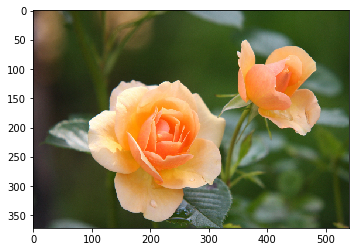

In [0]:
base_dir = '/content/gdrive/My Drive/adp_project/test1.jpg'
data = []
image = glob.glob(base_dir)
img = io.imread(image[0])
print(img.shape)
img = transform.resize(img, (372, 540))

data.append(img[:192, :192, :3])
data.append(img[-192:, :192, :3])
data.append(img[:192, 174:366, :3])
data.append(img[-192:, 174:366, :3])
data.append(img[:192, -192:, :3])
data.append(img[-192:, -192:, :3])
print(type(data))

#imgplot = plt.imshow(img)

newImg = np.stack([data[0], data[1], data[2], data[3],data[4],data[5]],axis=0)
print(type(newImg))

canvas = np.zeros((372, 540, 3))
canvas[:192, :192,:] = data[0]
canvas[-192:, :192, :] = data[1]
canvas[:192, 174:366, :] = data[2]
canvas[-192:, 174:366, :3] = data[3]
canvas[:192, -192:, :] = data[4]
canvas[-192:, -192:, :3] = data[5]

imgplot = plt.imshow(canvas)


In [0]:
!ls /content/gdrive/My\ Drive/adp_project/checkPoint



checkpoint			       model.ckpt-111999.index
model.ckpt-103999.data-00000-of-00001  model.ckpt-111999.meta
model.ckpt-103999.index		       model.ckpt-115999.data-00000-of-00001
model.ckpt-103999.meta		       model.ckpt-115999.index
model.ckpt-107999.data-00000-of-00001  model.ckpt-115999.meta
model.ckpt-107999.index		       model.ckpt-119999.data-00000-of-00001
model.ckpt-107999.meta		       model.ckpt-119999.index
model.ckpt-111999.data-00000-of-00001  model.ckpt-119999.meta


In [0]:
from skimage import transform, io
import numpy as np
import tensorflow as tf

import glob 
import scipy as sp
from scipy import io
from scipy import interpolate
from scipy import ndimage
import os
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-alpha0


In [0]:
tf.reset_default_graph()
global graph,model
graph = tf.get_default_graph()

AttributeError: ignored

In [0]:
lfsize = [372, 540, 8, 8] #dimensions of Lytro light fields
batchsize = 1 #modify based on user's GPU memory
patchsize = [192, 192] #spatial dimensions of training light fields  ----- x * y
disp_mult = 4.0 #max disparity between adjacent veiws
num_crops = 4 #number of random spatial crops per light field for each input queue thread to push
learning_rate = 0.001
train_iters = 120000


In [0]:
def weight_variable(w_shape):
    return tf.get_variable('weights', w_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def bias_variable(b_shape, init_bias=0.0):
    return tf.get_variable('bias', b_shape, initializer=tf.constant_initializer(init_bias))

def cnn_layer(input_tensor, w_shape, b_shape, layer_name, rate=1, ds=1):
    with tf.variable_scope(layer_name):
        W = weight_variable(w_shape)
        pad_amt_0 = rate * (w_shape[0] - 1)//2
        pad_amt_1 = rate * (w_shape[1] - 1)//2
        input_tensor = tf.pad(input_tensor, [[0,0],[pad_amt_0,pad_amt_0],[pad_amt_1,pad_amt_1],[0,0]], mode='SYMMETRIC')
        h = tf.nn.convolution(input_tensor, W, strides=[ds, ds], padding='VALID', dilation_rate=[rate, rate], name=layer_name + '_conv')
        h = tf.contrib.layers.instance_norm(h + bias_variable(b_shape))
        h = tf.nn.leaky_relu(h)
        return h
    
def cnn_layer_plain(input_tensor, w_shape, b_shape, layer_name, rate=1, ds=1):
    with tf.variable_scope(layer_name):
        W = weight_variable(w_shape)
        pad_amt_0 = rate * (w_shape[0] - 1)//2
        pad_amt_1 = rate * (w_shape[1] - 1)//2
        input_tensor = tf.pad(input_tensor, [[0,0],[pad_amt_0,pad_amt_0],[pad_amt_1,pad_amt_1],[0,0]], mode='SYMMETRIC')
        h = tf.nn.convolution(input_tensor, W, strides=[ds, ds], padding='VALID', dilation_rate=[rate, rate], name=layer_name + '_conv')
        h = h + bias_variable(b_shape)
        return h
    
def cnn_layer_3D(input_tensor, w_shape, b_shape, layer_name, rate=1, ds=1):
    with tf.variable_scope(layer_name):
        W = weight_variable(w_shape)
        pad_amt_0 = rate * (w_shape[0] - 1)//2
        pad_amt_1 = rate * (w_shape[1] - 1)//2
        pad_amt_2 = rate * (w_shape[2] - 1)//2
        input_tensor = tf.pad(input_tensor, [[0,0],[pad_amt_0,pad_amt_0],[pad_amt_1,pad_amt_1],[pad_amt_2,pad_amt_2],[0,0]], mode='SYMMETRIC')
        h = tf.nn.convolution(input_tensor, W, strides=[ds, ds, ds], padding='VALID', dilation_rate=[rate, rate, rate], name=layer_name + '_conv')
        h = tf.contrib.layers.instance_norm(h + bias_variable(b_shape))
        h = tf.nn.leaky_relu(h)
        return h
    
def cnn_layer_3D_plain(input_tensor, w_shape, b_shape, layer_name, rate=1, ds=1):
    with tf.variable_scope(layer_name):
        W = weight_variable(w_shape)
        pad_amt_0 = rate * (w_shape[0] - 1)//2
        pad_amt_1 = rate * (w_shape[1] - 1)//2
        pad_amt_2 = rate * (w_shape[2] - 1)//2
        input_tensor = tf.pad(input_tensor, [[0,0],[pad_amt_0,pad_amt_0],[pad_amt_1,pad_amt_1],[pad_amt_2,pad_amt_2],[0,0]], mode='SYMMETRIC')
        h = tf.nn.convolution(input_tensor, W, strides=[ds, ds, ds], padding='VALID', dilation_rate=[rate, rate, rate], name=layer_name + '_conv')
        h = h + bias_variable(b_shape)
        return h


def depth_network(x, lfsize, disp_mult, name):
    with tf.variable_scope(name):
        
        b_sz = tf.shape(x)[0]
        y_sz = tf.shape(x)[1]
        x_sz = tf.shape(x)[2]
        v_sz = lfsize[2]
        u_sz = lfsize[3]
        
        c1 = cnn_layer(x, [3, 3, 3, 16], [16], 'c1')
        c2 = cnn_layer(c1, [3, 3, 16, 64], [64], 'c2')
        c3 = cnn_layer(c2, [3, 3, 64, 128], [128], 'c3')
        c4 = cnn_layer(c3, [3, 3, 128, 128], [128], 'c4', rate=2)    #what is rate?
        c5 = cnn_layer(c4, [3, 3, 128, 128], [128], 'c5', rate=4)
        c6 = cnn_layer(c5, [3, 3, 128, 128], [128], 'c6', rate=8)
        c7 = cnn_layer(c6, [3, 3, 128, 128], [128], 'c7', rate=16)
        c8 = cnn_layer(c7, [3, 3, 128, 128], [128], 'c8')
        c9 = cnn_layer(c8, [3, 3, 128, lfsize[2]*lfsize[3]], [lfsize[2]*lfsize[3]], 'c9')
        c10 = disp_mult*tf.tanh(cnn_layer_plain(c9, [3, 3, lfsize[2]*lfsize[3], lfsize[2]*lfsize[3]], \
                                                [lfsize[2]*lfsize[3]], 'c10'))
        
        return tf.reshape(c10, [b_sz, y_sz, x_sz, v_sz, u_sz])



def occlusions_network(x, shear, lfsize, name):
    with tf.variable_scope(name):
        
        b_sz = tf.shape(x)[0]
        y_sz = tf.shape(x)[1]
        x_sz = tf.shape(x)[2]
        v_sz = lfsize[2]
        u_sz = lfsize[3]
        
        x = tf.transpose(tf.reshape(tf.transpose(x, perm=[0, 5, 1, 2, 3, 4]), \
                                    [b_sz, 4, y_sz, x_sz, u_sz*v_sz]), perm=[0, 4, 2, 3, 1])     #transpose  compress??
        
        c1 = cnn_layer_3D(x, [3, 3, 3, 4, 8], [8], 'c1')
        c2 = cnn_layer_3D(c1, [3, 3, 3, 8, 8], [8], 'c2')
        c3 = cnn_layer_3D(c2, [3, 3, 3, 8, 8], [8], 'c3')
        c4 = cnn_layer_3D(c3, [3, 3, 3, 8, 8], [8], 'c4')
        c5 = tf.tanh(cnn_layer_3D_plain(c4, [3, 3, 3, 8, 3], [3], 'c5'))
        
        output = tf.transpose(tf.reshape(tf.transpose(c5, perm=[0, 4, 2, 3, 1]), \
                                         [b_sz, 3, y_sz, x_sz, v_sz, u_sz]), perm=[0, 2, 3, 4, 5, 1]) + shear

                
        return output



def forward_model(x, lfsize, disp_mult):
    with tf.variable_scope('forward_model') as scope:
        #predict ray depths from input image
        ray_depths = depth_network(x, lfsize, disp_mult, 'ray_depths')
        #shear input image by predicted ray depths to render Lambertian light field
        lf_shear_r = depth_rendering(x[:, :, :, 0], ray_depths, lfsize)
        lf_shear_g = depth_rendering(x[:, :, :, 1], ray_depths, lfsize)
        lf_shear_b = depth_rendering(x[:, :, :, 2], ray_depths, lfsize)
        lf_shear = tf.stack([lf_shear_r, lf_shear_g, lf_shear_b], axis=5)   #light field
        #occlusion/non-Lambertian prediction network
        #tf.stack --> combine multiple tensor into one tensor
        shear_and_depth = tf.stack([lf_shear_r, lf_shear_g, lf_shear_b, tf.stop_gradient(ray_depths)], axis=5) # axis = 5?
        y = occlusions_network(shear_and_depth, lf_shear, lfsize, 'occlusions')  # occlusion/non-Lambertian prediction
        return ray_depths, lf_shear, y



def depth_rendering(central, ray_depths, lfsize):
    with tf.variable_scope('depth_rendering') as scope:
        b_sz = tf.shape(central)[0]
        y_sz = tf.shape(central)[1]
        x_sz = tf.shape(central)[2]
        u_sz = lfsize[2]
        v_sz = lfsize[3]
        
        central = tf.expand_dims(tf.expand_dims(central, 3), 4) #add two dimention to 4d tensor
                                                
        #create and reparameterize light field grid
        b_vals = tf.to_float(tf.range(b_sz))  # array of float
        v_vals = tf.to_float(tf.range(v_sz)) - tf.to_float(v_sz)/2.0   # why need decrease by /2 ????
        u_vals = tf.to_float(tf.range(u_sz)) - tf.to_float(u_sz)/2.0
        y_vals = tf.to_float(tf.range(y_sz))
        x_vals = tf.to_float(tf.range(x_sz))
    
        b, y, x, v, u = tf.meshgrid(b_vals, y_vals, x_vals, v_vals, u_vals, indexing='ij')
               
        #warp coordinates by ray depths
        y_t = y + v * ray_depths
        x_t = x + u * ray_depths
        
        v_r = tf.zeros_like(b)
        u_r = tf.zeros_like(b)
        
        #indices for linear interpolation
        b_1 = tf.to_int32(b)
        y_1 = tf.to_int32(tf.floor(y_t))
        y_2 = y_1 + 1
        x_1 = tf.to_int32(tf.floor(x_t))
        x_2 = x_1 + 1
        v_1 = tf.to_int32(v_r)
        u_1 = tf.to_int32(u_r)
        
        y_1 = tf.clip_by_value(y_1, 0, y_sz-1)
        y_2 = tf.clip_by_value(y_2, 0, y_sz-1)
        x_1 = tf.clip_by_value(x_1, 0, x_sz-1)
        x_2 = tf.clip_by_value(x_2, 0, x_sz-1)
        
        #assemble interpolation indices
        interp_pts_1 = tf.stack([b_1, y_1, x_1, v_1, u_1], -1)
        interp_pts_2 = tf.stack([b_1, y_2, x_1, v_1, u_1], -1)
        interp_pts_3 = tf.stack([b_1, y_1, x_2, v_1, u_1], -1)
        interp_pts_4 = tf.stack([b_1, y_2, x_2, v_1, u_1], -1)
        
        #gather light fields to be interpolated
        lf_1 = tf.gather_nd(central, interp_pts_1)  #get specific indice of input value
        lf_2 = tf.gather_nd(central, interp_pts_2)
        lf_3 = tf.gather_nd(central, interp_pts_3)
        lf_4 = tf.gather_nd(central, interp_pts_4)
        
        #calculate interpolation weights
        y_1_f = tf.to_float(y_1)
        x_1_f = tf.to_float(x_1)
        d_y_1 = 1.0 - (y_t - y_1_f)
        d_y_2 = 1.0 - d_y_1
        d_x_1 = 1.0 - (x_t - x_1_f)
        d_x_2 = 1.0 - d_x_1
        
        w1 = d_y_1 * d_x_1
        w2 = d_y_2 * d_x_1
        w3 = d_y_1 * d_x_2
        w4 = d_y_2 * d_x_2
        
        lf = tf.add_n([w1*lf_1, w2*lf_2, w3*lf_3, w4*lf_4])
                        
    return lf



def transform_ray_depths(ray_depths, u_step, v_step, lfsize):
    with tf.variable_scope('transform_ray_depths') as scope:
        b_sz = tf.shape(ray_depths)[0]
        y_sz = tf.shape(ray_depths)[1]
        x_sz = tf.shape(ray_depths)[2]
        u_sz = lfsize[2]
        v_sz = lfsize[3]
                                                        
        #create and reparameterize light field grid
        b_vals = tf.to_float(tf.range(b_sz))
        v_vals = tf.to_float(tf.range(v_sz)) - tf.to_float(v_sz)/2.0
        u_vals = tf.to_float(tf.range(u_sz)) - tf.to_float(u_sz)/2.0
        y_vals = tf.to_float(tf.range(y_sz))
        x_vals = tf.to_float(tf.range(x_sz))
    
        b, y, x, v, u = tf.meshgrid(b_vals, y_vals, x_vals, v_vals, u_vals, indexing='ij')
               
        #warp coordinates by ray depths
        y_t = y + v_step * ray_depths
        x_t = x + u_step * ray_depths
        
        v_t = v - v_step + tf.to_float(v_sz)/2.0
        u_t = u - u_step + tf.to_float(u_sz)/2.0
        
        #indices for linear interpolation
        b_1 = tf.to_int32(b)
        y_1 = tf.to_int32(tf.floor(y_t))
        y_2 = y_1 + 1
        x_1 = tf.to_int32(tf.floor(x_t))
        x_2 = x_1 + 1
        v_1 = tf.to_int32(v_t)
        u_1 = tf.to_int32(u_t)
        
        y_1 = tf.clip_by_value(y_1, 0, y_sz-1)
        y_2 = tf.clip_by_value(y_2, 0, y_sz-1)   ## filter ?
        x_1 = tf.clip_by_value(x_1, 0, x_sz-1)
        x_2 = tf.clip_by_value(x_2, 0, x_sz-1)
        v_1 = tf.clip_by_value(v_1, 0, v_sz-1)
        u_1 = tf.clip_by_value(u_1, 0, u_sz-1)
        
        #assemble interpolation indices
        interp_pts_1 = tf.stack([b_1, y_1, x_1, v_1, u_1], -1)
        interp_pts_2 = tf.stack([b_1, y_2, x_1, v_1, u_1], -1)
        interp_pts_3 = tf.stack([b_1, y_1, x_2, v_1, u_1], -1)
        interp_pts_4 = tf.stack([b_1, y_2, x_2, v_1, u_1], -1)
        
        #gather light fields to be interpolated
        lf_1 = tf.gather_nd(ray_depths, interp_pts_1)
        lf_2 = tf.gather_nd(ray_depths, interp_pts_2)
        lf_3 = tf.gather_nd(ray_depths, interp_pts_3)
        lf_4 = tf.gather_nd(ray_depths, interp_pts_4)
        
        #calculate interpolation weights
        y_1_f = tf.to_float(y_1)
        x_1_f = tf.to_float(x_1)
        d_y_1 = 1.0 - (y_t - y_1_f)
        d_y_2 = 1.0 - d_y_1
        d_x_1 = 1.0 - (x_t - x_1_f)
        d_x_2 = 1.0 - d_x_1
        
        w1 = d_y_1 * d_x_1
        w2 = d_y_2 * d_x_1
        w3 = d_y_1 * d_x_2
        w4 = d_y_2 * d_x_2
        
        lf = tf.add_n([w1*lf_1, w2*lf_2, w3*lf_3, w4*lf_4])
                        
    return lf

def depth_consistency_loss(x, lfsize):
    x_u = transform_ray_depths(x, 1.0, 0.0, lfsize)
    x_v = transform_ray_depths(x, 0.0, 1.0, lfsize)
    x_uv = transform_ray_depths(x, 1.0, 1.0, lfsize)
    d1 = (x[:,:,:,1:,1:]-x_u[:,:,:,1:,1:])
    d2 = (x[:,:,:,1:,1:]-x_v[:,:,:,1:,1:])
    d3 = (x[:,:,:,1:,1:]-x_uv[:,:,:,1:,1:])
    l1 = tf.reduce_mean(tf.abs(d1)+tf.abs(d2)+tf.abs(d3))
    return l1


def image_derivs(x, nc):
    dy = tf.nn.depthwise_conv2d(x, tf.tile(tf.expand_dims(tf.expand_dims([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]], 2), 3), [1, 1, nc, 1]), strides=[1, 1, 1, 1], padding='VALID')
    dx = tf.nn.depthwise_conv2d(x, tf.tile(tf.expand_dims(tf.expand_dims([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]], 2), 3), [1, 1, nc, 1]), strides=[1, 1, 1, 1], padding='VALID')
    return dy, dx

def tv_loss(x):
    b_sz = tf.shape(x)[0]
    y_sz = tf.shape(x)[1]
    x_sz = tf.shape(x)[2]
    u_sz = lfsize[2]
    v_sz = lfsize[3]
    temp = tf.reshape(x, [b_sz, y_sz, x_sz, u_sz*v_sz])
    dy, dx = image_derivs(temp, u_sz*v_sz)
    l1 = tf.reduce_mean(tf.abs(dy)+tf.abs(dx))
    return l1

In [0]:
def normalize_lf(lf):
    return 2.0*(lf-0.5)    

#input image is [;;;]  --- > [5250, 7560, 4]
def process_lf(lf, num_crops, lfsize, patchsize):     # get 5d light field and 3d alif
    gamma_val = tf.random_uniform(shape=[], minval=0.4, maxval=1.0) #random gamma for data augmentation (change at test time, I suggest 0.4-0.5)
    
    #scaling with the gamma
    lf = normalize_lf(tf.image.adjust_gamma(tf.to_float(lf[:lfsize[0]*14, :lfsize[1]*14, :])/255.0, gamma=gamma_val))
    lf = tf.transpose(tf.reshape(lf, [lfsize[0], 14, lfsize[1], 14, 3]), [0, 2, 1, 3, 4])       #[372,540,14,14,3]
    lf = lf[:, :, (14//2)-(lfsize[2]//2):(14//2)+(lfsize[2]//2), (14//2)-(lfsize[3]//2):(14//2)+(lfsize[3]//2), :]   #[372,540,3:11,3:11,3]
    aif = lf[:, :, lfsize[2]//2, lfsize[3]//2, :]     #[372,540,4,4,3]    center imgae
    aif_list = []
    lf_list = []
    for i in range(num_crops):
        r = tf.random_uniform(shape=[], minval=0, maxval=tf.shape(lf)[0]-patchsize[0], dtype=tf.int32)
        c = tf.random_uniform(shape=[], minval=0, maxval=tf.shape(lf)[1]-patchsize[1], dtype=tf.int32)
        aif_list.append(aif[r:r+patchsize[0], c:c+patchsize[1], :])    #[random (192,192,3))]       numb of crop = 4  .....?????choose one of 4
        lf_list.append(lf[r:r+patchsize[0], c:c+patchsize[1], :, :, :])  #[random (192,192,8,8,3))]  
    return aif_list, lf_list

def read_lf(filename_queue, num_crops, lfsize, patchsize):
    value = tf.read_file(filename_queue[0])
    lf = tf.image.decode_image(value, channels=3)
    aif_list, lf_list = process_lf(lf, num_crops, lfsize, patchsize)
    return aif_list, lf_list

def input_pipeline(filenames, lfsize, patchsize, batchsize, num_crops):   #create batches by randomly shuffling tensors
    filename_queue = tf.train.slice_input_producer([filenames], shuffle=True)   #shuffle the file path?
    example_list = [read_lf(filename_queue, num_crops, lfsize, patchsize) for _ in range(2)] #number of threads for populating queue  2 output
    min_after_dequeue = 0
    capacity = 8
    aif_batch, lf_batch = tf.train.shuffle_batch_join(example_list, batch_size=batchsize, capacity=capacity,
                                                      min_after_dequeue=min_after_dequeue, enqueue_many=True,
                                                      shapes=[[patchsize[0], patchsize[1], 3],    #192,192,3
                                                              [patchsize[0], patchsize[1], lfsize[2], lfsize[3], 3]])   #192,192,8,8,3
    return aif_batch, lf_batch

train_path = '/content/gdrive/My Drive/adp_project/test' #path to training examples
train_filenames = [os.path.join(train_path, f) for f in os.listdir(train_path) if not f.startswith('.')]

#aif - input image 
#lf - groud truth light field
aif_batch, lf_batch = input_pipeline(train_filenames, lfsize, patchsize, batchsize, num_crops)


AttributeError: ignored

In [0]:
aif_batch, lf_batch = input_pipeline(train_filenames, lfsize, patchsize, batchsize, num_crops)

ray_depths, lf_shear, y = forward_model(aif_batch, lfsize, disp_mult)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.


In [0]:
checkPoint_dir = '/content/gdrive/My Drive/adp_project/checkPoint/model.ckpt-119999.meta'
with tf.Session() as sess:
  with graph.as_default():
    init = tf.global_variables_initializer()
    sess.run(init)
    print('init finished')
    new_saver = tf.train.import_meta_graph(checkPoint_dir)
    new_saver.restore(sess, tf.train.latest_checkpoint('/content/gdrive/My Drive/adp_project/checkPoint/'))
    sess.run(y)

init finished
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/adp_project/checkPoint/model.ckpt-119999
